In [1]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Prepare MNIST Data for Training

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
# Define the preprocessing transformation
class BinaryTransform:
    def __call__(self, x):
        # Convert the image to a numpy array, normalize to [0, 1], and apply the threshold
        x = np.array(x) / 255.0  # Normalize pixel values to [0, 1]
        x = (x >= 0.4).astype(np.float32)  # Apply threshold to convert to binary (0s and 1s)
        return torch.from_numpy(x)  # Convert back to PyTorch tensor

# Create the transform with binary conversion
transform = transforms.Compose([
    BinaryTransform(),  # Apply the custom binary transformation
])
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='mnist_data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='mnist_data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [4]:
train_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: mnist_data
     Split: Train
     StandardTransform
 Transform: Compose(
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: mnist_data
     Split: Test
     StandardTransform
 Transform: Compose(
            ))

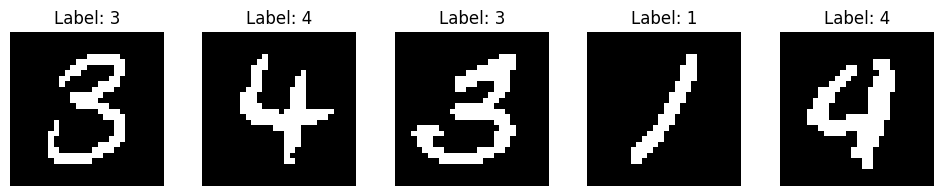

In [6]:
# Function to display a grid of images
def show_images(images, labels, title="MNIST Images"):
    images = images.numpy()  # Convert torch tensor to NumPy array
    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    for i, ax in enumerate(axes):
        ax.imshow(np.squeeze(images[i]), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')  # Hide axis
    plt.show()

# Get a batch of training data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 5 images
show_images(images[:5], labels[:5])

## Simple Feed Forward Neural Network

In [14]:
class MNISTChar(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), 
            nn.ReLU(), 
            nn.Linear(512, 512), 
            nn.ReLU(),
            nn.Linear(512,10), 
        )

    def forward(self, x):
        x  = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits 




In [15]:
import torch.optim as optim 
from tqdm import tqdm
model = MNISTChar().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.01)

In [16]:
model

MNISTChar(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Convolutional NN

In [8]:
import torch.nn.functional as F 

In [6]:

class Conv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        """
        This function initializes the parameters for a conv2D layer

        Parameters
        ------------
        in_channels : int
        Number of channels in the input image

        out_channels : int
        Number of channels produced by the convolution

        kernel_size : int or tuple
        Size of the convolving kernel 

        stride : int or tuple
        Stride of the convolution. Default: 1

        padding: int, tuple or str
        Padding added to all four sides of the input. Default: 'same'
        """
        super(Conv2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.out_channels, self.in_channels, *self.kernel_size),
                    requires_grad=True
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_channels,), requires_grad=True)
        )

    def forward(self, x):
        """
        This function performs convolution operation on the input
        Parameters
        ------------
        x : tensor, float32
        Input image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        feature map output from the last layer
        """
        x = F.conv2d(x, self.weight, self.bias, stride=self.stride, padding=self.padding)
        x = F.relu(x)

        return x

In [5]:
class MaxPool2D(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        """
        This function initializes the parameters for a maxpool layer

        Parameters
        ------------
        kernel_size : int
        window height and width for the maxpooling window

        stride : int
        the stride of the window. Default value is kernel_size

        padding: int
        implicit zero padding to be added on both sides
        """
        super(MaxPool2D, self).__init__()
        self.kernel_size = kernel_size
        self.stride = kernel_size if stride is None else stride
        self.padding = padding


    def forward(self, x): 
        """
        This function performs max-pool operation on the input

        Parameters
        ------------
        x : tensor, float32
        Input image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        max-pooled output from the last layer
        """
        x = F.max_pool2d(x, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        return x

In [7]:
class Dense(nn.Module):
    def __init__(self, in_features, out_features):
        """
        This function initializes the parameters for a dense layer
        Parameters
        ------------- 
        in_features : int
        shape of the input to the dense layer

        out_features : int
        number of units in the dense layer
        """
        super(Dense, self).__init__()
        self.in_features = in_features
        self.out_features =  out_features
        
        self.weight = nn.Parameter(
            torch.nn.init.xavier_uniform_(
                torch.empty(
                    (self.in_features, self.out_features),
                    requires_grad=True,
                )
            )
        )
        self.bias = nn.Parameter(
            torch.zeros((self.out_features,), requires_grad=True)
        )

    def forward(self, x):
        """
        This function performs dense operation on the input
        Parameters
        ------------
        x : tensor, float32
        Input flattened image to the convolution layer

        Returns
        ------------
        x : tensor, float32
        linear operation output from the last layer
        """
        return torch.mm(x, self.weight) + self.bias


In [10]:
class MNISTCNN(nn.Module):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        filter_dim = 3
        in_channels = [1, 16, 32, 32]
        out_channels = [16, 32, 32, 64]

        dense_in_features = [4096, 256]
        dense_out_features = [256, 10]

        self.c1 = Conv2D(in_channels[0], out_channels[0], filter_dim)
        self.c1 = Conv2D(in_channels[1], out_channels[1], filter_dim)
        self.maxp1 = MaxPool2D(2)
        self.dropout = nn.Dropout(p = 0.25)
        self.c3 = Conv2D(in_channels[2], out_channels[2], filter_dim)
        self.c4 = Conv2D(in_channels[3], out_channels[3], filter_dim)
        self.maxp2 = MaxPool2D(2)
        self.d1 = Dense(dense_in_features[1], dense_out_features[1])

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        x = self.maxp1(x)
        x = self.dropout(x)

        x = self.c3(x)
        x = self.c4(x)
        x = self.maxp2(x)
        x = self.dropout(x)

        x = torch.flatten(x, start_dim = 1)
        x = self.d1(x)
        x = F.relu(x)

        x = self.d2(x)
        return x
        
        

In [12]:
model = MNISTCNN()

In [13]:
example = torch.randn((1, 1, 28,28))
output = model(example)
model

RuntimeError: Given groups=1, weight of size [32, 16, 3, 3], expected input[1, 1, 28, 28] to have 16 channels, but got 1 channels instead

## The Training Loop

In [17]:
def train(model, criterion, optimizer,train_loader, val_loader,  epochs = 10):
   # Training and validation loop
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):  # Train for 5 epochs
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for batch in progress_bar:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())  
        
        # Compute average training loss
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
       
       # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch[0].to(device), batch[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Get the predicted labels
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        # Compute average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct / len(val_subset)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

In [18]:
train_losses, val_losses, val_accuracies = train(model, criterion, optimizer, train_loader, val_loader, epochs=10)


Epoch 1/10: 100%|██████████| 750/750 [00:08<00:00, 86.39batch/s, loss=0.0629]


Epoch [1/10], Train Loss: 0.2945, Validation Loss: 0.2482, Validation Accuracy: 0.9381


Epoch 2/10: 100%|██████████| 750/750 [00:08<00:00, 85.08batch/s, loss=0.0964]


Epoch [2/10], Train Loss: 0.1778, Validation Loss: 0.1725, Validation Accuracy: 0.9547


Epoch 3/10: 100%|██████████| 750/750 [00:08<00:00, 92.91batch/s, loss=0.236]   


Epoch [3/10], Train Loss: 0.1406, Validation Loss: 0.2593, Validation Accuracy: 0.9340


Epoch 4/10: 100%|██████████| 750/750 [00:07<00:00, 94.20batch/s, loss=0.309]   


Epoch [4/10], Train Loss: 0.1237, Validation Loss: 0.2002, Validation Accuracy: 0.9497


Epoch 5/10: 100%|██████████| 750/750 [00:08<00:00, 93.26batch/s, loss=0.038]   


Epoch [5/10], Train Loss: 0.1145, Validation Loss: 0.1965, Validation Accuracy: 0.9512


Epoch 6/10: 100%|██████████| 750/750 [00:08<00:00, 90.05batch/s, loss=0.106]   


Epoch [6/10], Train Loss: 0.1032, Validation Loss: 0.1653, Validation Accuracy: 0.9586


Epoch 7/10: 100%|██████████| 750/750 [00:08<00:00, 89.19batch/s, loss=0.0642]  


Epoch [7/10], Train Loss: 0.1000, Validation Loss: 0.1500, Validation Accuracy: 0.9649


Epoch 8/10: 100%|██████████| 750/750 [00:07<00:00, 106.02batch/s, loss=0.019]  


Epoch [8/10], Train Loss: 0.0944, Validation Loss: 0.1643, Validation Accuracy: 0.9616


Epoch 9/10: 100%|██████████| 750/750 [00:07<00:00, 99.05batch/s, loss=0.184]   


Epoch [9/10], Train Loss: 0.0882, Validation Loss: 0.1570, Validation Accuracy: 0.9600


Epoch 10/10: 100%|██████████| 750/750 [00:08<00:00, 90.47batch/s, loss=0.00639] 


Epoch [10/10], Train Loss: 0.0867, Validation Loss: 0.1734, Validation Accuracy: 0.9599


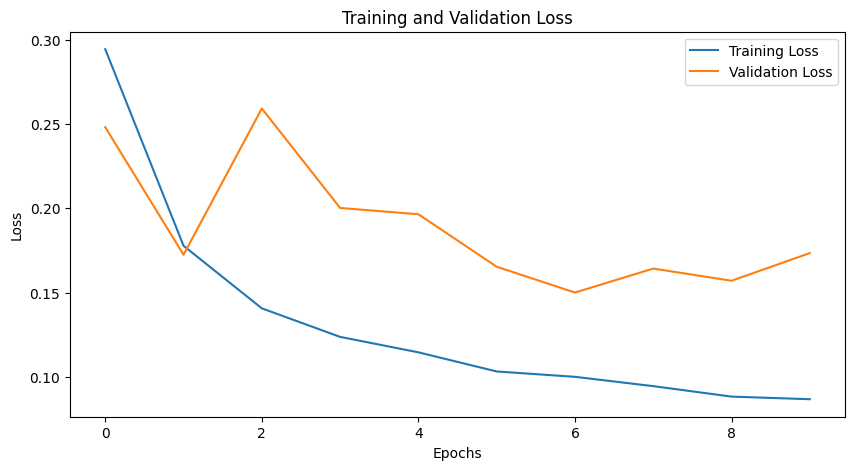

In [19]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Evaluation

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()


In [30]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

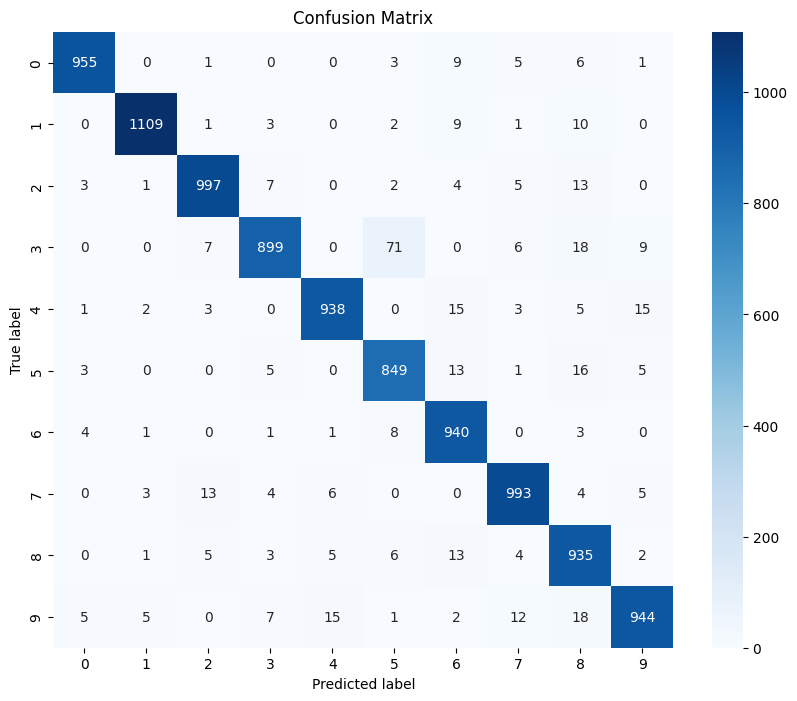

In [31]:
y_true, y_pred = evaluate_model(model, test_loader)
classes = [str(i) for i in range(10)]  # Class names for MNIST (0-9)
plot_confusion_matrix(y_true, y_pred, classes)

In [32]:
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct / len(test_dataset)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Test the trained model
test(model, test_loader)

Test Loss: 0.1914, Test Accuracy: 0.9559


In [116]:
# Assuming `dataloader` is your DataLoader object
data_iter = iter(test_loader)

# Get the first batch of images and labels
images, labels = next(data_iter)

# Extract the first image and its label from the batch
single_image = images[0]
single_label = labels[0]

# Display the shape of the image
print("Image shape:", single_image.shape)
print("Label:", single_label)


Image shape: torch.Size([1, 28, 28])
Label: tensor(7)


In [118]:
output = model(single_image.to(device))

In [119]:
output

tensor([[-21.8901,   0.1444,  -2.1180,  -5.7034,  -0.5495,  -1.6681, -12.3653,
          12.2284,  -8.2639,   2.9288]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [33]:
# Export the model to TorchScript
device = torch.device('cpu')
model.to(device)
example = torch.rand(1,28, 28).to(device)
model.eval()  # Set the model to evaluation mode
scripted_model = torch.jit.trace(model,example)  # Use torch.jit.trace for tracing if needed
scripted_model.save('mnist_model.pt')  # Save the model

In [37]:
import pandas as pd
import numpy as np

# Read the data from the CSV file into a DataFrame
im1 = pd.read_csv('matrix.csv', header=None)  # Use header=None to prevent the first row from being interpreted as column names

# Convert the DataFrame to a NumPy array
im1 = im1.to_numpy().flatten()  # Flatten to ensure it's a 1D array

# Reshape the flattened array into a 28x28 matrix
if im1.size == 28 * 28:  # Ensure the data has the correct size
    im1 = im1.reshape(28, 28)  # Reshape into (1, 28, 28) format for further processing
else:
    print(f"Error: Expected 784 values, but found {im1.size}.")

In [38]:
im1.shape

(28, 28)

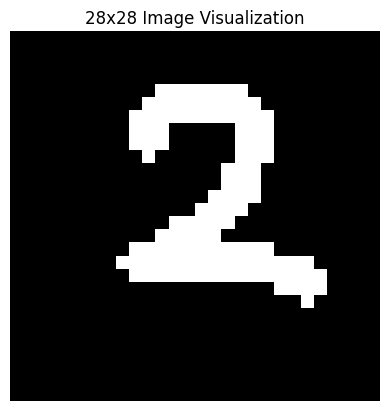

In [39]:
# Visualize the image using matplotlib
plt.imshow(im1, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.title('28x28 Image Visualization')
plt.axis('off')  # Hide axis ticks
plt.show()  # Display the image